In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [2]:
data = np.load('data/imagenet/imagenet-resnet152.npz')
example_paths = os.listdir('data/imagenet/examples')
smx = data['smx']
labels = data['labels'].astype(int)

# Il y a 50 000 images dans le jeu de données data
# Chaque image a un numéro (example_indexes) et un label associé
# Il y a 1 000 labels différents
# Un élement de la table smx (une image) est une liste de 1 000 valeurs (softmax scores / proba) obtenues à partir
# d'un prédicteur (supposément réseaux de neurones).

print(list(data.keys()))
print(data['smx'][:3])
print("//")
print(data['labels'][:3])
print("//")
print(data['example_indexes'][:3])
print("//")

['smx', 'labels', 'example_indexes']
[[5.55347383e-01 1.32564350e-03 5.25403069e-04 ... 1.47947849e-05
  3.24599205e-05 1.63325603e-06]
 [9.64658678e-01 1.35036071e-05 2.15132957e-07 ... 8.14401858e-07
  1.33911101e-07 6.87838053e-09]
 [3.58310223e-01 2.08239749e-06 5.65229820e-05 ... 1.50919902e-07
  1.05871993e-06 3.43750139e-09]]
//
[0. 0. 0.]
//
[16256 11680 48281]
//


In [3]:
# Problem setup
n=1000 # number of calibration points
alpha = 0.1 # 1-alpha is the desired coverage

In [4]:
# Split the softmax scores into calibration and validation sets (save the shuffling)
idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0
np.random.shuffle(idx)
# ix est un vecteur de taille 50 000 (nb d'images) qui contient n True et 50 000 - n False disposé aléatoirement
cal_smx, val_smx = smx[idx,:], smx[~idx,:]
cal_labels, val_labels = labels[idx], labels[~idx]

### Conformal prediction happens here

In [5]:
# 1: get conformal scores. n = calib_Y.shape[0]
cal_scores = 1-cal_smx[np.arange(n),cal_labels]
# Pour chacunes des images du set de calibration, score de conformité = 1-softmax associé au vrai label (liste de n éléments)
# score de conformité élevé quand softmax faible = prédiction du model mauvaise

# 2: get adjusted quantile
q_level = np.ceil((n+1)*(1-alpha))/n
qhat = np.quantile(cal_scores, q_level, interpolation='higher') # valeur du 9 ème décile environ

# 3: form prediction sets
prediction_sets = val_smx >= (1-qhat)
# Pour chaque image du set de validation, on garde les labels dont le softmax dépasse le seuil (on remplace les valeurs par True/False) 

In [6]:
# Calculate empirical coverage
empirical_coverage = prediction_sets[np.arange(prediction_sets.shape[0]),val_labels].mean()
# On regarde en moyenne si le set de prédiction contient bien le vrai label
print(f"The empirical coverage is: {empirical_coverage}")

The empirical coverage is: 0.899795918367347


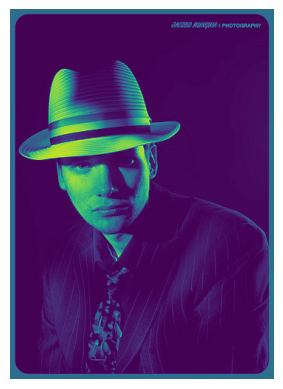

The prediction set is: ['cowboy hat', 'sombrero', 'suit']


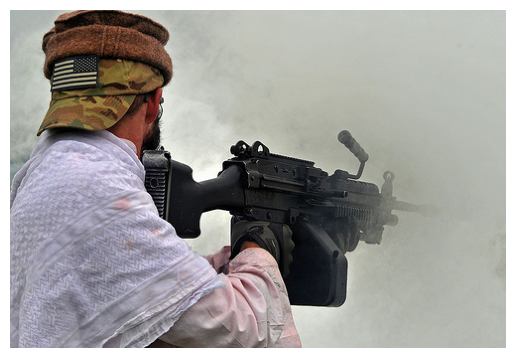

The prediction set is: ['assault rifle', 'rifle']


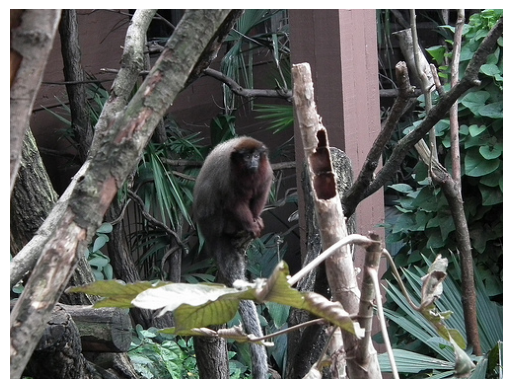

The prediction set is: ['macaque', 'marmoset', 'white-headed capuchin', 'titi']


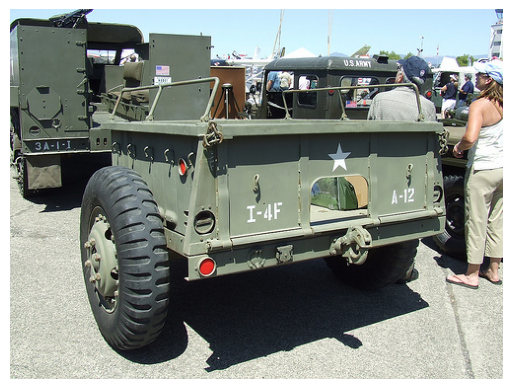

The prediction set is: ['amphibious vehicle', 'half-track']


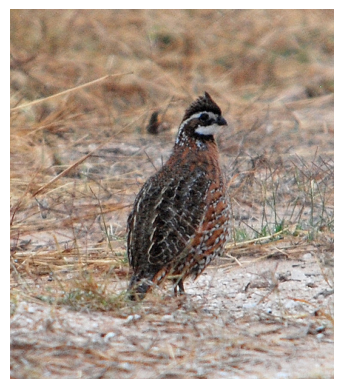

The prediction set is: ['quail']


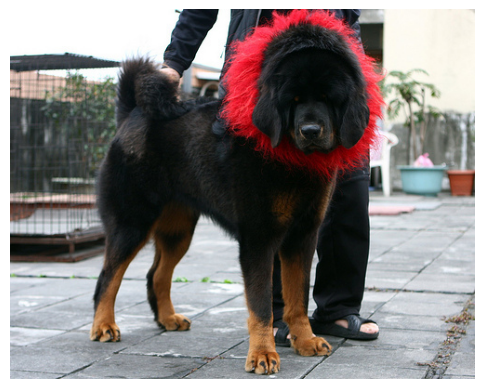

The prediction set is: ['Tibetan Mastiff']


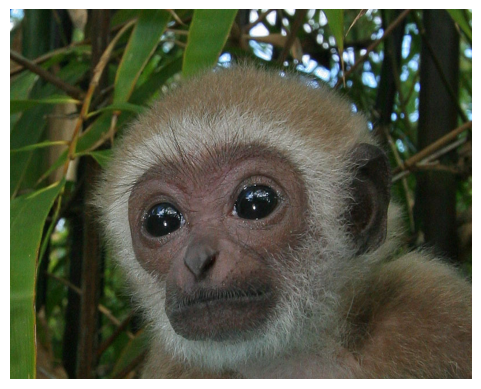

The prediction set is: ['patas monkey', 'black-and-white colobus', 'white-headed capuchin', 'titi', "Geoffroy's spider monkey", 'common squirrel monkey']


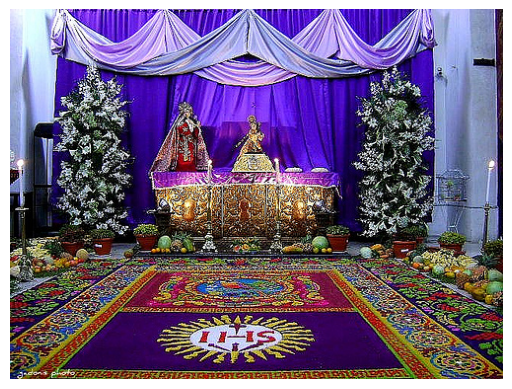

The prediction set is: ['altar', 'front curtain', 'throne']


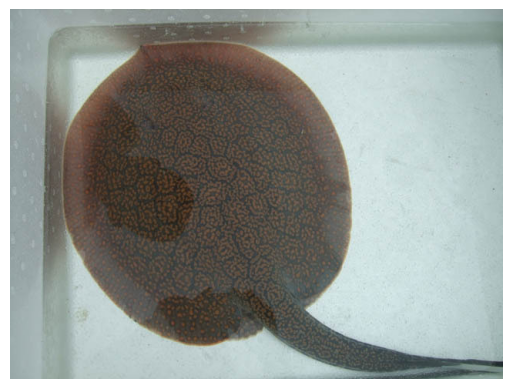

The prediction set is: ['electric ray']


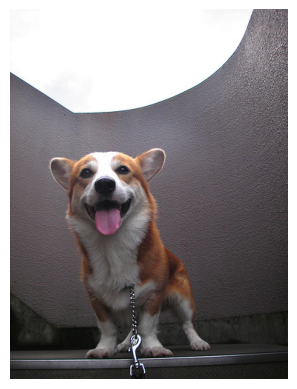

The prediction set is: ['Pembroke Welsh Corgi']


In [7]:
# Show some examples
with open('data/imagenet/human_readable_labels.json') as f:
    label_strings = np.array(json.load(f))

example_paths =os.listdir('data/imagenet/examples')
for i in range(10):
    rand_path = np.random.choice(example_paths)
    img = imread('data/imagenet/examples/' + rand_path )
    img_index = int(rand_path.split('.')[0])
    prediction_set = smx[img_index] > 1-qhat
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(f"The prediction set is: {list(label_strings[prediction_set])}")

# Les sets de prédiction vide ou de grande taille soulignent une incertitude du prédicteur
# Tandis qu'un set d'un seul élèment témoigne d'une plus grande confiance dans la prédiction

### This method leads to small sets, but sacrifices adaptivity. [Click this link](https://github.com/aangelopoulos/conformal-prediction/blob/main/notebooks/imagenet-raps.ipynb) for an improvement.

This method was studied in https://arxiv.org/abs/1609.00451.